# Vårt superprosjekt

## a

We initalize and test the functionality of Qiskit as follows

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from scipy.optimize import minimize
from qiskit import QuantumCircuit,Aer,assemble, ClassicalRegister,QuantumRegister, execute, transpile
from qiskit.visualization import array_to_latex, plot_histogram,plot_bloch_vector, plot_state_city, plot_bloch_multivector,plot_state_qsphere
from qiskit.quantum_info import DensityMatrix, Statevector
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.opflow import X, Z, I, AerPauliExpectation
from qiskit.primitives import Estimator

#optimizer = partial(minimize, method="L-BFGS-B")
state_sim = Aer.get_backend('statevector_simulator')
simulator = Aer.get_backend('aer_simulator')


I = np.eye(2)
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])
pauli_x = np.matrix([[0,1],[1,0]])
pauli_z = np.matrix([[1,0],[0,-1]])

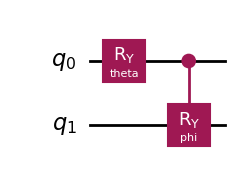

In [33]:
from qiskit.circuit import QuantumCircuit,\
                           Parameter
var_par1 = Parameter('theta')
var_par2 = Parameter('phi')

qc_ = QuantumCircuit(2)

qc_.ry(var_par1,0)
qc_.cry(var_par2,0,1)
qc_.draw()
qc_.draw(output = 'mpl', style =  'iqx', filename = 'ansatz.pdf')

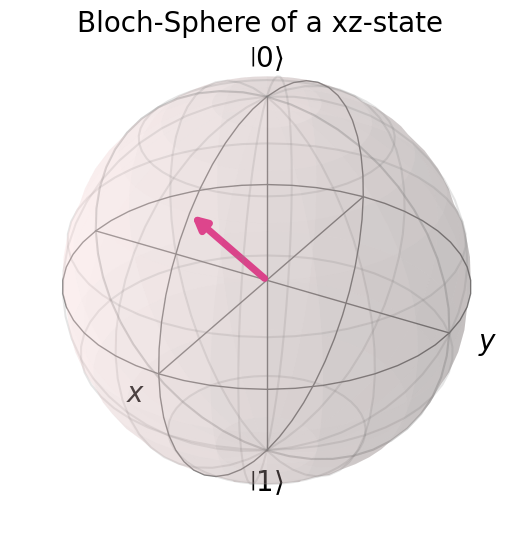

In [24]:
a = np.sqrt(2)
plot_bloch_vector([1/a,0,1/a], title="Bloch-Sphere of a xz-state")

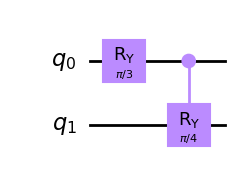

In [58]:
qc_par = qc_.bind_parameters({var_par1: np.pi/3, var_par2: np.pi/4})

qc_par.draw('mpl')

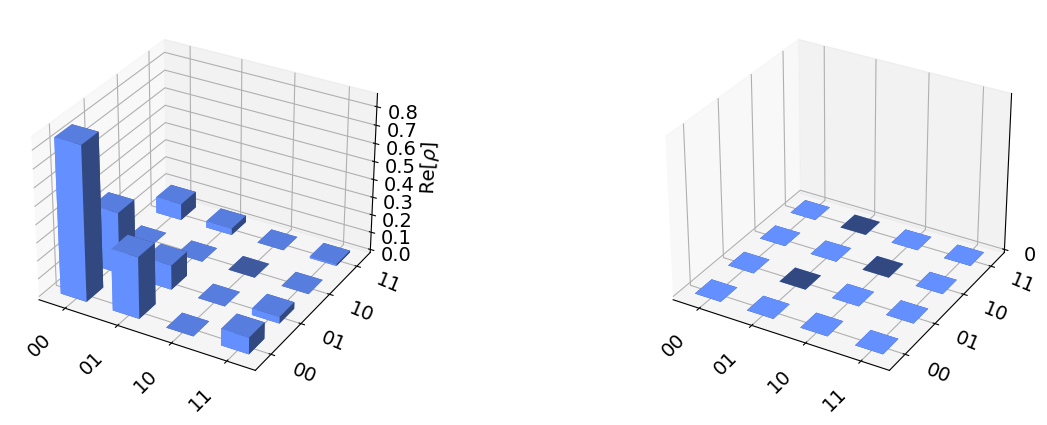

In [26]:
state = Statevector(qc_par)
plot_state_city(state)

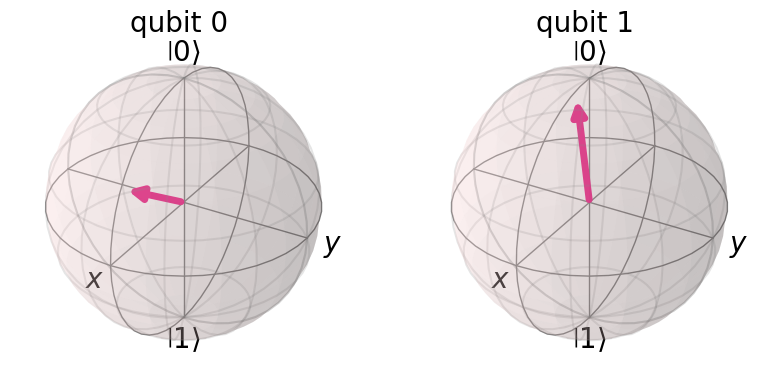

In [59]:
out1 = execute(qc_par,state_sim).result().get_statevector()
plot_bloch_multivector(out1)


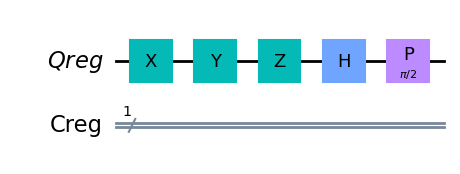

In [24]:
qr = QuantumRegister(1, 'Qreg')
cr = ClassicalRegister(1, 'Creg')

qc = QuantumCircuit()
qc.add_register(qr)
qc.add_register(cr)

qc.x(0)
qc.y(0)
qc.z(0)
qc.h(0)
qc.p(np.pi/2, 0)


qc.draw('mpl')

Initialize a Bell state by applying Haddamard to G0 and CNOT on G1, using G0 as control gate.

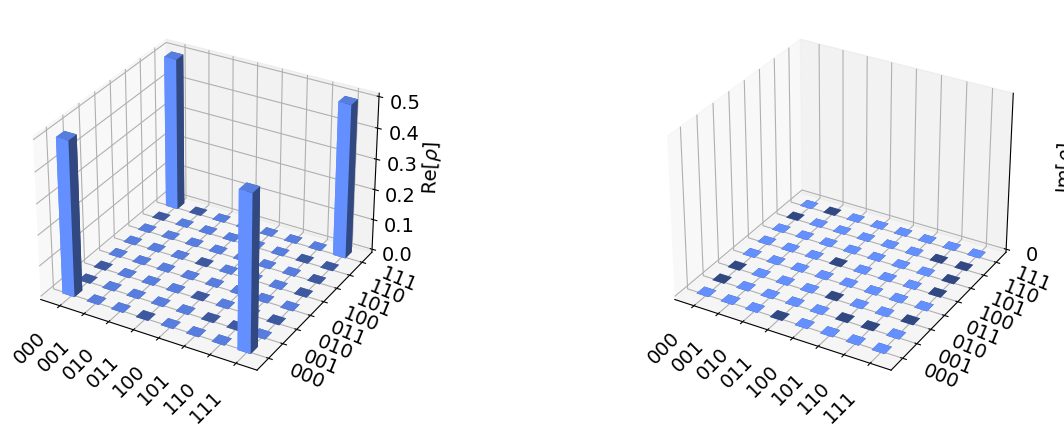

In [35]:
qc_2 = QuantumCircuit()

qr_2 = QuantumRegister(3, 'qreg')
qc_2.add_register(qr_2)

cr_2 = ClassicalRegister(3, 'creg')
qc_2.add_register(cr_2)
qc_2.h(0)
qc_2.cx(0,1)
qc_2.cx(1,2)

state = Statevector(qc_2)
plot_state_city(state)

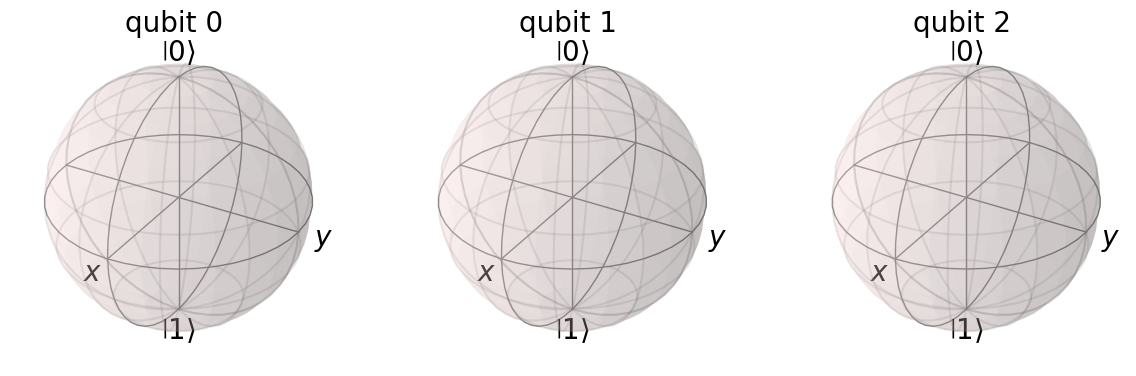

In [37]:
out1 = execute(qc_2,state_sim).result().get_statevector()
plot_bloch_multivector(out1)


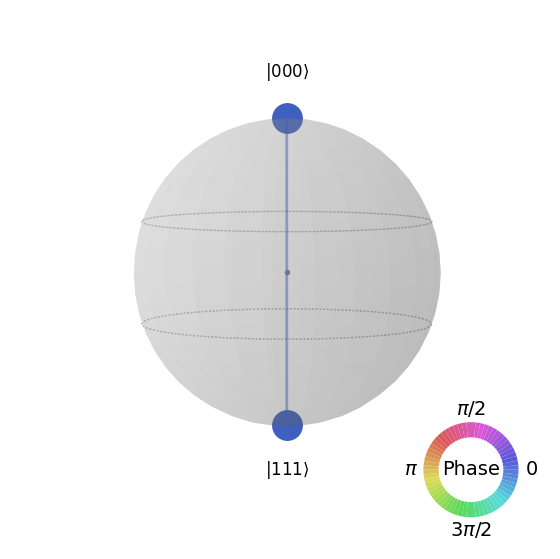

In [191]:
plot_state_qsphere(state)

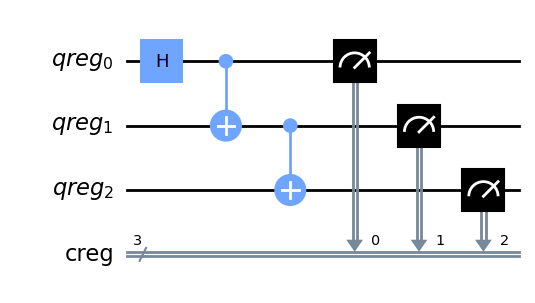

In [38]:
qc_2.measure(0,0)
qc_2.measure(1,1)
qc_2.measure(2,2)

qc_2.draw('mpl')

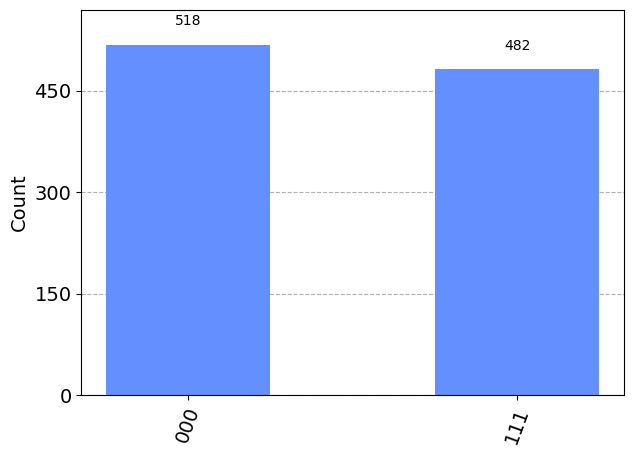

In [196]:
job = simulator.run(qc_2, shots=1000)
hist = job.result().get_counts()
plot_histogram(hist)

This is statistically in accordance with the expected GHZ states.

## b


Here we initialize the Hamiltonian matrices and solve it using eigsolvers.


[[2.         0.13333333]
 [0.13333333 2.        ]]

[2.13333333 1.86666667] 

 [[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]


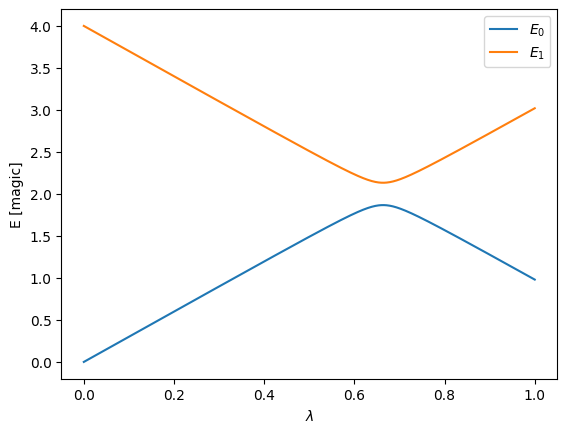

In [42]:
H0 = np.eye(2)
E1 = 0; E2 = 4
H0[0,0] = E1; H0[1,1] = E2


H1 = np.eye(2)
v11 = 3; v22 = -v11; v12 = 0.2; v21 = v12
H1[0,0] = v11; H1[0,1] = v12; H1[1,0] = v21; H1[1,1] = v22 

lmd_ = 2/3#Range [0,1]
pauli_x = np.matrix([[0,1],[1,0]])
pauli_z = np.matrix([[1,0],[0,-1]])
c = (v11 + v22)/2
omega_z = (v11-v22)/2
omega_x = v12

H_ = H0 + lmd_*H1

print(H_)
print()
eig_val, eig_vec = np.linalg.eig(H_)
print(eig_val,'\n\n', eig_vec)


n = 1000
lambdas = np.linspace(0,1,n)
Es = np.zeros((n,2))
C1s, C2s  = np.zeros_like(Es), np.zeros_like(Es)
for i, lmd_ in enumerate(lambdas):
    H_ = H0 + lmd_*H1
    eig_val, eig_vec = np.linalg.eigh(H_)
    # print(H_)
    Es[i,:] = eig_val
    C1s[i,:] = eig_vec[:,0]
    C2s[i,:] = eig_vec[:,1] 

fig, ax = plt.subplots()
ax.plot(lambdas, Es[:,0], label=r"$E_0$")
ax.plot(lambdas, Es[:,1], label=r"$E_1$")
ax.set(xlabel=r"$\lambda$", ylabel="E [magic]")
ax.legend() # Kan legge til fancy-pancy color bar for a vise "change of character" opplegget?

## c


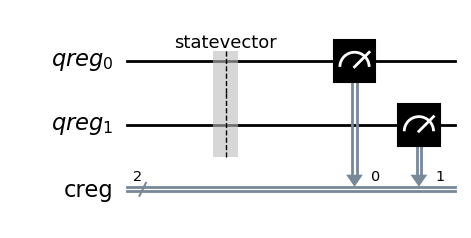

In [43]:
qc_3 = QuantumCircuit()

qr_3 = QuantumRegister(2, 'qreg')
qc_3.add_register(qr_3)

cr_3 = ClassicalRegister(2, 'creg')
qc_3.add_register(cr_3)

eta = (E1 + E2)/2
Omega = (E1-E2)/2
H0 = eta*np.eye(2) + Omega*pauli_z
are = Operator(Pauli('X'))

H1 = c * np.eye(2) + omega_z * pauli_z + omega_x * pauli_x

X_op = Operator(Pauli('X'))
Z_op = Operator(Pauli('Z'))
idty = Operator(np.eye(2))

qc_3.save_statevector()
qc_3.measure(qr_3[0], cr_3[0])
qc_3.measure(qr_3[1], cr_3[1])
qc_3.draw('mpl')

En måte:

In [44]:
I = np.eye(2)
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])

In [45]:
c = (v11 + v22)/2
omega_z = (v11-v22)/2
omega_x = v12
eta = (E1+E2)/2
omega_ = (E1-E2)/2

HH = eta*np.kron(I,I) + omega_ * np.kron(Z,I) + c * np.kron(I,I) + omega_z * np.kron(I,Z) + omega_x * np.kron(I,X) 
val, vec = np.linalg.eig(HH)
print(val)

h1_val = c + eta
h2_val = omega_
h3_val = omega_z
h4_val = omega_x

h1 = [h1_val, [0,1] , ['I']]
h2 = [h2_val, [0] , ['Z']]
h3 = [h3_val, [1] , ['Z']]
h4 = [h4_val, [1] , ['X']]

H = [h1,h2,h3,h4]
H

[ 3.00665928 -3.00665928  7.00665928  0.99334072]


[[2.0, [0, 1], ['I']],
 [-2.0, [0], ['Z']],
 [3.0, [1], ['Z']],
 [0.2, [1], ['X']]]

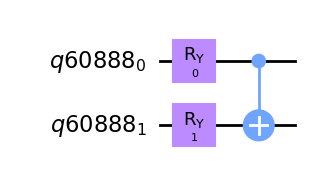

In [46]:
def ansatz(theta,n_qubits):
    qreg = QuantumRegister(n_qubits)
    circuit = QuantumCircuit(qreg)
    param_list =[]
    for j in range(len(theta)):
        par = Parameter('theta %s' %j)
        param_list.append(par)
    for i in range(n_qubits):
        circuit.ry(param_list[i],qreg[i])
    for i in range(n_qubits-1):
        circuit.cx(qreg[i],qreg[i+1])
    dictus ={}
    for j in range(len(theta)):
        dictus[param_list[j]] = theta[j]
    circuit = circuit.bind_parameters(dictus)
    return(circuit)

cc = ansatz([0,1], 2)
cc.draw('mpl')

Before ansatz


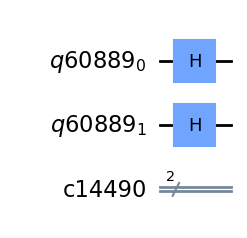

In [47]:
n_qbits = 2
theta = np.random.randn(2)

qc = QuantumCircuit()
qreg = QuantumRegister(2)
creg = ClassicalRegister(2)

qc.add_register(qreg)
qc.add_register(creg)
qc.h(qreg[:])

print('Before ansatz')
qc.draw('mpl')

After ansatz


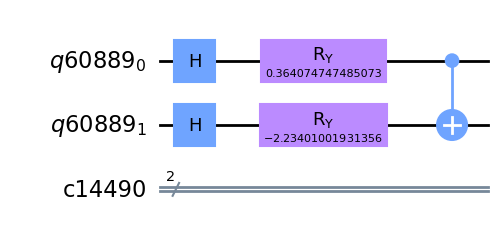

In [48]:
qc = qc.compose(ansatz(theta,n_qbits))
print('After ansatz')
qc.draw('mpl')

In [49]:
def basis_change(h_i,n_qubits):
    qreg = QuantumRegister(n_qubits)
    circuit = QuantumCircuit(qreg)
    for qubit,operator in zip(h_i[1],h_i[2]):
        if operator == 'X':
            circuit.h(qreg[qubit]) 
    return(circuit)

After basis transformation:


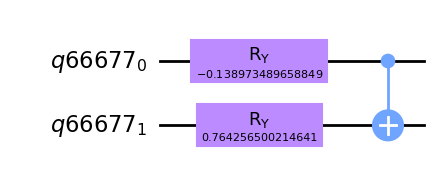

In [145]:
n_qubits = 2
theta = np.random.randn(n_qubits)

qreg = QuantumRegister(n_qubits)
qc = QuantumCircuit(qreg)
qc = qc.compose(ansatz(theta,n_qubits))
qc = qc.compose(basis_change(H[0],n_qubits))
print('After basis transformation:')
qc.draw('mpl')

In [50]:
def get_energy(theta):
    n_qubits = 2
    qreg = QuantumRegister(n_qubits)
    qc = QuantumCircuit(qreg)
    qc = qc.compose(ansatz(theta,n_qubits))
    qc_list = []
    for idx,h_i in enumerate(H):
        basis_change_circuit = basis_change(h_i,n_qubits)
        new_qc = qc.compose(basis_change_circuit)
        creg = ClassicalRegister(len(h_i[1]))
        new_qc.add_register(creg)
        new_qc.measure(qreg[h_i[1]],creg)
        qc_list.append(new_qc)
        
    shots = 1000
    job = simulator.run(qc_list,shots=shots)
    E = np.zeros(len(qc_list))
    for i in range(len(E)):
        result = job.result()
        counts = result.get_counts(i)
        for key,value in counts.items():
            e = 1
            for bit in key:
                if bit == '0':
                    e *= 1
                if bit == '1':
                    e *= -1
            E[i] += e*value
        E[i] *= H[i][0]
    E /= shots
    return(np.sum(E))

theta = np.random.randn(2)

get_energy(theta)

1.1332

In [51]:
def compute_gradient(theta, epsilon=1e-2):
    gradient = np.zeros_like(theta)
    for i in range(len(theta)):
        theta_plus = np.copy(theta)
        theta_minus = np.copy(theta)
        theta_plus[i] += epsilon  #np.pi/10   
        theta_minus[i] -= epsilon #np.pi/10  
        energy_plus = get_energy(theta_plus)
        energy_minus = get_energy(theta_minus)
        gradient[i] = ((energy_plus - energy_minus) / (2 * epsilon))
    return gradient

def gradient_descent(theta, learning_rate, num_iterations):
    min_theta = theta
    min_eval  = get_energy(theta)
    for iteration in range(num_iterations):
        energy = get_energy(theta)
        gradient = compute_gradient(theta)
        theta -= (learning_rate * gradient)
        """
        if iteration%10 == True:
            print("Iteration:", iteration, "Energy:", energy)
        """
        if energy < min_eval:
            min_theta = theta 
            min_eval  = energy
    return min_theta, min_eval

theta = np.array([0.1,0.1])
learning_rate = 0.08
num_iterations = 1000

arg_best, arg_val  = gradient_descent(theta, learning_rate, num_iterations)
print("The lowest energy is:",arg_val,"with theta values of", arg_best)

The lowest energy is: -7.0264 with theta values of [-6.484  -2.8152]


## d

In [20]:

lmd_ = 0.4
s_00 = np.array([1,0,0,0])
s_10 = np.array([0,1,0,0])
s_01 = np.array([0,0,1,0])
s_11 = np.array([0,0,0,1])
s_0 = np.array([1,0])
s_1 = np.array([0,1])


eps_list = [0,2.5,6.5,7]
H0 = np.eye(4)
H0[0,0] = eps_list[0];H0[1,1] = eps_list[1];H0[2,2] = eps_list[2];H0[3,3] = eps_list[3]

pauli_x = np.matrix([[0,1],[1,0]])
pauli_z = np.matrix([[1,0],[0,-1]])
H_x = 2.0
H_z = 3.0
H_I = H_x * np.kron(pauli_x, pauli_x) + H_z * np.kron(pauli_z, pauli_z)

H_tot = H0 + lmd_*H_I
eig_vals, eig_vecs = np.linalg.eig(H_tot)
#print(eig_vecs)

eig_vecs = np.square(eig_vecs)
rho_d = eig_vecs.T @ eig_vecs

print(rho_d)
#Computing partial density matrix
#rho_a = (eig_vecs[0,0]**2 + eig_vecs[0,1]**2) * np.outer(s_0,s_0) + (eig_vecs[0,2]**2 + eig_vecs[0,3]**2) * np.outer(s_1,s_1)
#rho_b = (eig_vecs[0,0]**2 + eig_vecs[0,2]**2) * np.outer(s_0,s_0) + (eig_vecs[0,1]**2 + eig_vecs[0,3]**2) * np.outer(s_1,s_1)
#tol = 1e-3

#print(rho_a)
#print(rho_b)
#print(np.log(rho_a+tol))
#print()
#print(np.trace(rho_b))
#Compute entropy
#S_a = - np.trace(rho_a)*np.log(np.trace(rho_a+tol))
#S_b = - np.trace(rho_b)*np.log(np.trace(rho_b)+tol)
#var = np.trace(np.log(rho_a))
#print(rar)
#print(S_a, S_b)


[[0.97517455 0.02482545 0.         0.        ]
 [0.02482545 0.97517455 0.         0.        ]
 [0.         0.         0.93103448 0.06896552]
 [0.         0.         0.06896552 0.93103448]]


In [38]:
lmd_ = 2
H_tot = H0 + lmd_*H_I
eig_vals0, eig_vecs0 = np.linalg.eig(H0)
eig_vals_i, eig_vecs_i = np.linalg.eig(lmd_*H_I)

eig_vals, eig_vecs = np.linalg.eig(H_tot)
permute = eig_vals.argsort()
eig_vals = eig_vals[permute]
eig_vecs = eig_vecs[:,permute]
DM = np.outer(eig_vecs[:,0], eig_vecs[:,0])

d = np.matrix([[1,0],[0,1]])

v1 = [1,0]
proj1 = np.kron(v1,d)
x1 = proj1@DM@proj1.T


v2 = [0,1]
proj2 = np.kron(v2,d)
x2 = proj2@DM@proj2.T


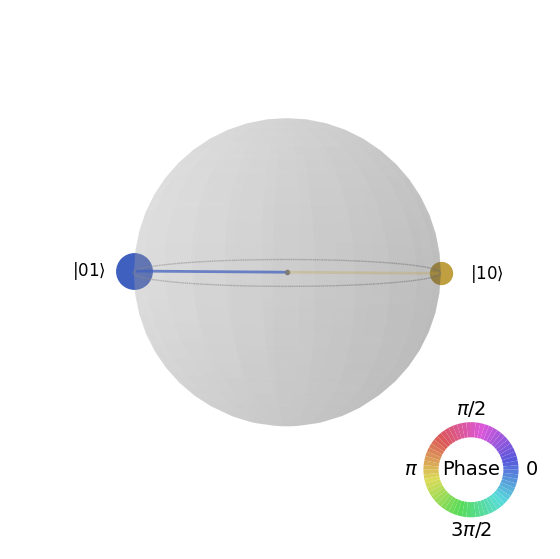

In [40]:
plot_state_qsphere(DM)

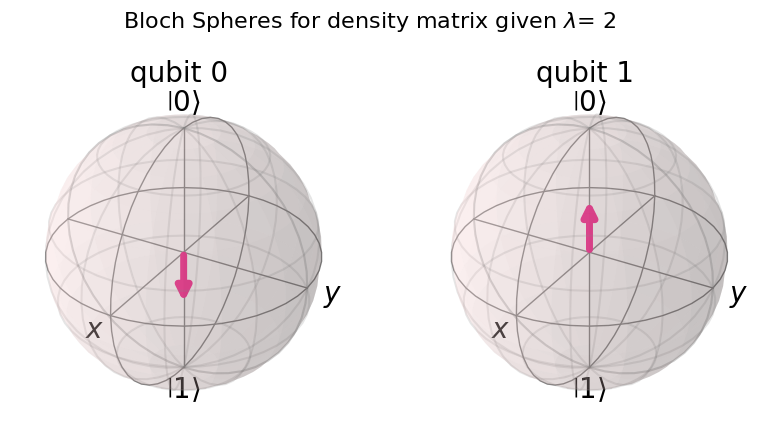

In [47]:
plot_bloch_multivector(DM, title=f'Bloch Spheres for density matrix given $\lambda$= {lmd_}')


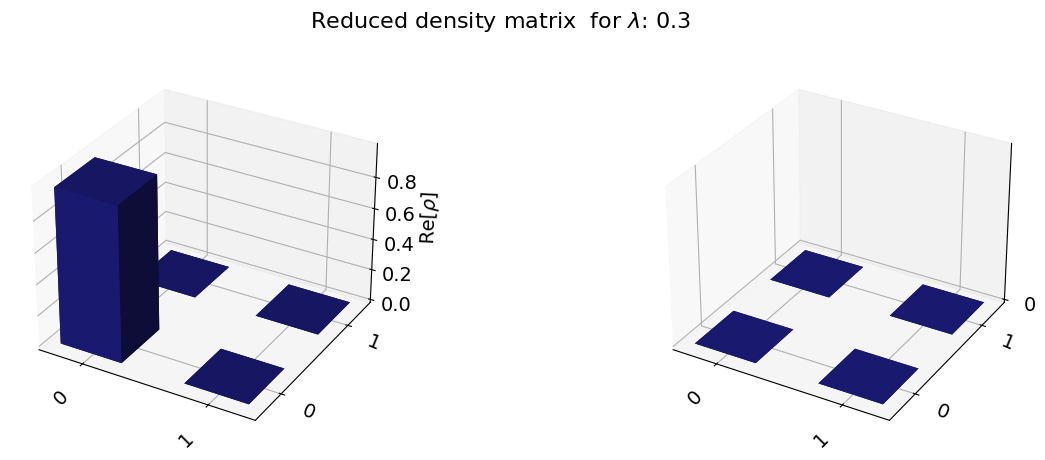

In [91]:
plot_state_city(x1, color=['midnightblue', 'midnightblue'], title=f'Reduced density matrix  for $ \lambda$: {lmd_}')

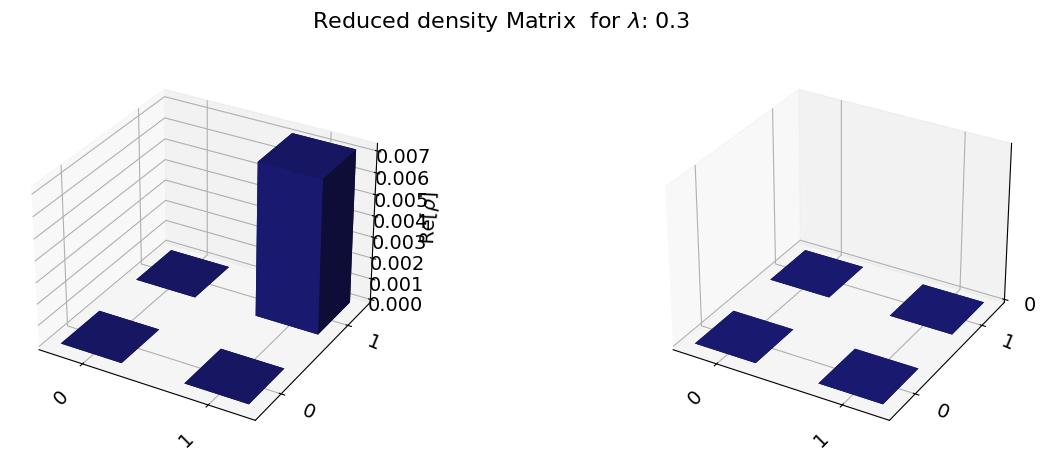

In [92]:
plot_state_city(x2, color=['midnightblue', 'midnightblue'], title=f'Reduced density Matrix  for $\lambda$: {lmd_}')

In [17]:
def entropy(lmd_):
    H_tot = H0 + lmd_*H_I
    eig_vals, eig_vecs = np.linalg.eig(H_tot)
    #print(eig_vecs)
    #print()
    #Computing partial density matrix
    rho_a = (eig_vecs[0,0]**2 + eig_vecs[0,1]**2) * np.outer(s_0,s_0) + (eig_vecs[0,2]**2 + eig_vecs[0,3]**2) * np.outer(s_1,s_1)
    rho_b = (eig_vecs[0,0]**2 + eig_vecs[0,2]**2) * np.outer(s_0,s_0) + (eig_vecs[0,1]**2 + eig_vecs[0,3]**2) * np.outer(s_1,s_1)
    #Compute entropy
    S_a = - np.trace(rho_a)*np.log2(np.trace(rho_a))
    S_b = - np.trace(rho_b)*np.log2(np.trace(rho_b))
    return S_a, S_b

lambda_list = np.linspace(0, 2, 100)
rho_a_list = []
rho_b_list = []
for i in range(len(lambda_list)):
    S_a_var, S_b_var = entropy(lambda_list[i])
    rho_a_list.append(S_a_var)
    rho_b_list.append(S_b_var)
    
plt.figure()
#plt.plot(lambda_list,rho_a_list)
plt.title('Entropy as a function of connection strength')
plt.xlabel('v')
plt.ylabel('$S_{a}$')
plt.savefig('entropy.pdf')
plt.plot(lambda_list,rho_b_list)
plt.show()

NameError: name 'H0' is not defined

## e

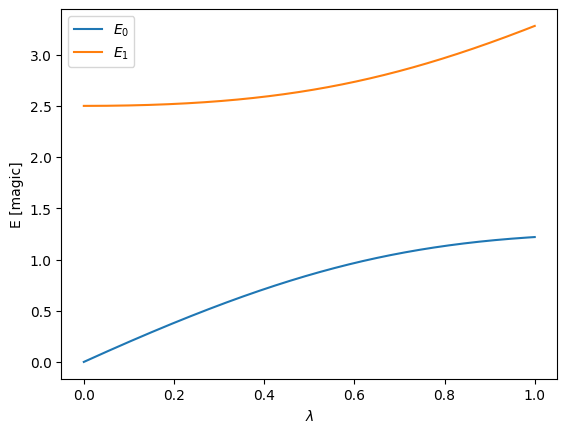

In [20]:
n = 1000
lambdas = np.linspace(0,1,n)
Es = np.zeros((n,4))
C1s, C2s  = np.zeros_like(Es), np.zeros_like(Es)

for i, lmd_ in enumerate(lambdas):
    H_ = H0 + lmd_*H1
    eig_val, eig_vec = np.linalg.eigh(H_)
    Es[i,:] = eig_val

fig, ax = plt.subplots()
ax.plot(lambdas, Es[:,0], label=r"$E_0$")
ax.plot(lambdas, Es[:,1], label=r"$E_1$")
ax.set(xlabel=r"$\lambda$", ylabel="E [magic]")
ax.legend() 

The entropy is as expected, similar, as there are no difference in the configuration of the two states. As such, there should be an equal amount of entanglement entropy. The energies follow the same asymptotic convergence, which indeed confirms their entanglement.

In [4]:
I = np.eye(2)
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])
hx = 2; hz = 3; eps_list = [0,2.5,6.5,7]

H_0 = np.matrix([[eps_list[0],0,0,0],[0,eps_list[1],0,0],[0,0,eps_list[2],0],[0,0,0,eps_list[3]]])
H_I = hx * np.kron(X,X) + hz* np.kron(Z,Z) 
H = H_0 + H_I
eigvals,eigvecs = np.linalg.eigh(H)
print(eigvals)
print(eigvecs)

c_1 = 1
c_2 = 1
c_3 = 1

h_1 = [c_1,[0],['z,z']]
h_2 = [c_2,[1],['x,x']]
H = [h_1,h_2]

[-1.32842712  2.46887113  4.32842712 10.53112887]
[[-0.         -0.96649965  0.         -0.25666794]
 [ 0.92387953  0.         -0.38268343  0.        ]
 [-0.38268343  0.         -0.92387953  0.        ]
 [ 0.          0.25666794  0.         -0.96649965]]


In [11]:
n_qubits= 2
qreg = QuantumRegister(n_qubits)
circuit = QuantumCircuit(qreg)
circuit.h(qreg[:2])
print('Before ansatz')
print(circuit.draw())
theta = np.random.randn(2)
n_qubits = 2
circuit = circuit.compose(ansatz(theta,n_qubits))
print('After ansatz')
print(circuit.draw())

Before ansatz
       ┌───┐
q22_0: ┤ H ├
       ├───┤
q22_1: ┤ H ├
       └───┘
After ansatz
       ┌───┐  ┌────────────────────┐                                     
q22_0: ┤ H ├──┤ Ry(1.240977277925) ├───■──────────────────────────────■──
       ├───┤┌─┴────────────────────┴┐┌─┴─┐┌────────────────────────┐┌─┴─┐
q22_1: ┤ H ├┤ Ry(0.172650179574386) ├┤ X ├┤ Ry(-0.172650179574386) ├┤ X ├
       └───┘└───────────────────────┘└───┘└────────────────────────┘└───┘


In [12]:
def basis_change(h_i,n_qubits):
    qreg = QuantumRegister(n_qubits)
    circuit = QuantumCircuit(qreg)
    
    for qubit,operator in zip(h_i[1],h_i[2]):
        if operator == 'x':
            circuit.h(qreg[qubit])
    return(circuit)
n_qubits = 2
qreg = QuantumRegister(n_qubits)
circuit = QuantumCircuit(qreg)
theta = np.random.randn(n_qubits)
circuit = circuit.compose(ansatz(theta,n_qubits))
print('Ansatz circuit')
print(circuit.draw())
circuit = circuit.compose(basis_change(H[1],n_qubits))
print('After basis transformation:')
print(circuit.draw())

Ansatz circuit
         ┌──────────────────────┐                                     
q26_0: ──┤ Ry(1.28400587416963) ├───■──────────────────────────────■──
       ┌─┴──────────────────────┴┐┌─┴─┐┌────────────────────────┐┌─┴─┐
q26_1: ┤ Ry(-0.0568234524659587) ├┤ X ├┤ Ry(0.0568234524659587) ├┤ X ├
       └─────────────────────────┘└───┘└────────────────────────┘└───┘
After basis transformation:
         ┌──────────────────────┐                                     
q26_0: ──┤ Ry(1.28400587416963) ├───■──────────────────────────────■──
       ┌─┴──────────────────────┴┐┌─┴─┐┌────────────────────────┐┌─┴─┐
q26_1: ┤ Ry(-0.0568234524659587) ├┤ X ├┤ Ry(0.0568234524659587) ├┤ X ├
       └─────────────────────────┘└───┘└────────────────────────┘└───┘


In [16]:
def get_energy(theta):
    n_qubits = 2
    qreg = QuantumRegister(n_qubits)
    circuit = QuantumCircuit(qreg)
    circuit = circuit.compose(ansatz(theta,n_qubits))
    circuit_list = []
    for idx,h_i in enumerate(H):
        basis_change_circuit = basis_change(h_i,n_qubits)
        new_circuit = circuit.compose(basis_change_circuit)
        creg = ClassicalRegister(len(h_i[1]))
        new_circuit.add_register(creg)
        new_circuit.measure(qreg[h_i[1]],creg)
        circuit_list.append(new_circuit)
    shots = 10000
    job = simulator.run(circuit_list,shots=shots)
    E = np.zeros(len(circuit_list))
    for i in range(len(circuit_list)):
        result = job.result()
        counts = result.get_counts(i)
        for key,value in counts.items():
            e = 1
            for bit in key:
                if bit == '0':
                    e *= 1
                if bit == '1':
                    e *= -1
            E[i] += e*value
        E[i] *= H[i][0]
    E /= shots
    return(np.sum(E)), circuit_list

theta = np.random.randn(2)
e, circ = get_energy(theta)
circ.draw()


AttributeError: 'list' object has no attribute 'draw'

In [99]:
def compute_gradient(theta, epsilon=1e-2):
    gradient = np.zeros_like(theta)
    for i in range(len(theta)):
        theta_plus = np.copy(theta)
        theta_minus = np.copy(theta)
        theta_plus[i] += epsilon  #np.pi/10   
        theta_minus[i] -= epsilon #np.pi/10  
        energy_plus = get_energy(theta_plus)
        energy_minus = get_energy(theta_minus)
        gradient[i] = ((energy_plus - energy_minus) / (2 * epsilon))
    return gradient

def gradient_descent(theta, learning_rate, num_iterations):
    min_theta = theta
    min_eval  = get_energy(theta)
    for iteration in range(num_iterations):
        energy = get_energy(theta)
        gradient = compute_gradient(theta)
        theta -= (learning_rate * gradient)
        """
        if iteration%10 == True:
            print("Iteration:", iteration, "Energy:", energy)
        """
        if energy < min_eval:
            min_theta = theta 
            min_eval  = energy
    return min_theta, min_eval

theta = np.array([0.1,0.1])
learning_rate = 0.08
num_iterations = 1000

arg_best, arg_val  = gradient_descent(theta, learning_rate, num_iterations)
print("The lowest energy is:",arg_val,"with theta values of", arg_best)

0 2.8587599999999997
1 2.5185999999999997
2 1.74168
3 0.23412000000000022
4 -2.06448
5 -4.63068
6 -6.2926400000000005
7 -6.95284
8 -7.1316
9 -7.18796
10 -7.19696
11 -7.19956
12 -7.2
13 -7.2
14 -7.19956
15 -7.1994
16 -7.1994
17 -7.2
18 -7.2
19 -7.2
20 -7.2
21 -7.2
22 -7.2
23 -7.2
24 -7.2
25 -7.2
26 -7.2
27 -7.1994
28 -7.2
29 -7.2
30 -7.2
31 -7.2
32 -7.2
33 -7.2
34 -7.2
35 -7.2
36 -7.2
37 -7.19996
38 -7.2
39 -7.2
40 -7.2
41 -7.2
42 -7.2
43 -7.2
44 -7.2
45 -7.2
46 -7.2
47 -7.2
48 -7.19996
49 -7.2
50 -7.2
51 -7.19996
52 -7.2
53 -7.2
54 -7.2
55 -7.2
56 -7.2
57 -7.2
58 -7.2
59 -7.2
60 -7.2
61 -7.2
62 -7.2
63 -7.1994
64 -7.2
65 -7.2
66 -7.2
67 -7.2
68 -7.2
69 -7.2
70 -7.2
71 -7.2
72 -7.2
73 -7.2
74 -7.2
75 -7.2
76 -7.2
77 -7.2
78 -7.2
79 -7.2
80 -7.2
81 -7.2
82 -7.2
83 -7.2
84 -7.2
85 -7.2
86 -7.2
87 -7.2
88 -7.2
89 -7.2
90 -7.1994
91 -7.2
92 -7.2
93 -7.2
94 -7.1994
95 -7.2
96 -7.19996
97 -7.2
98 -7.2
99 -7.2
100 -7.2
101 -7.2
102 -7.2
103 -7.2
104 -7.2
105 -7.2
106 -7.2
107 -7.2
108 -7.2
109

## f)

[-4.00000000e+00 -2.12178365e-16  4.00000000e+00 -0.00000000e+00]
[-3.16227766  3.16227766]


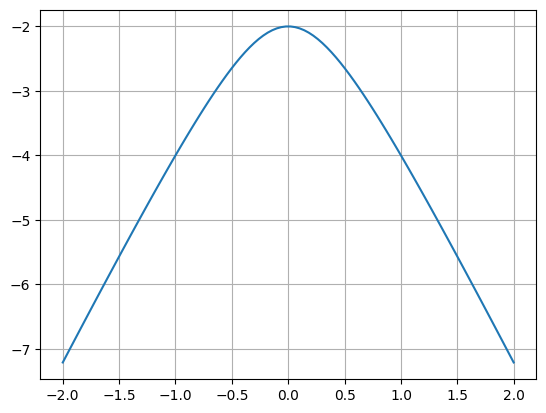

In [8]:
v =1
I = np.eye(2)
H_4 = -(np.kron(pauli_z,I) + np.kron(I, pauli_z)) - np.sqrt(6)/2 * v *(np.kron(pauli_x, I) + 
                                                                       np.kron(I, pauli_x) + 
                                                                       np.kron(pauli_x, pauli_z) - 
                                                                       np.kron(pauli_z, pauli_x))
def H4(v):
    reg = -(np.kron(pauli_z,I) + np.kron(I, pauli_z))
    ireg = - np.sqrt(6)/2 * v *(np.kron(pauli_x,I)+np.kron(I,pauli_x) +np.kron(pauli_x,pauli_z)-np.kron(pauli_z,pauli_x))
    ret = reg + ireg
    return ret
                                                                       
                                                                       
H_4_o = - pauli_z - 3*v*pauli_x


eigval_even, eigvec_even = np.linalg.eig(H_4)
eigval_odd, eigvec_odd = np.linalg.eig(H_4_o)

print(eigval_even)
print(eigval_odd)

H_op = Operator(H_4)


v_list = np.linspace(-2,2,100)
eigval_list = []
for i in range(len(v_list)):
    eig_temp, trash = np.linalg.eig(H4(v_list[i]))
    eigval_list.append(min(eig_temp))
    #print(v_list[i])
    #print(eig_temp)
    #print()
    
plt.plot(v_list, eigval_list)
plt.grid()

Disse verdiene stemmer på en såkalt prikk med analytiske verdier. Det er jo ganske lovende. Det er mulig her å lage noen fancy plot der vi varierer på v, eller tilnærmer Hartree-Fock?

Det er ganske snodig dette med VQE, men prøver bare:

In [9]:
def H4lip_func(v):
    h1_lip = [-1, [0,1], ['z']]
    h2_lip = [-np.sqrt(6)/2*v, [0], ['x']]
    h3_lip = [-np.sqrt(6)/2*v, [1], ['x']]
    h4_lip = [-np.sqrt(6)/2*v, [0,1], ['xz']]
    h5_lip = [np.sqrt(6)/2*v, [0,1], ['zx']]
    H4 = [h1_lip, h2_lip, h3_lip, h4_lip, h5_lip]
    return H4

In [10]:
from qiskit.circuit import QuantumCircuit,\
                           Parameter

def ansatz(theta,n_qubits):
    qreg = QuantumRegister(n_qubits)
    circuit = QuantumCircuit(qreg)
    param_list =[]
    for j in range(len(theta)):
        par = Parameter('theta %s' %j)
        param_list.append(par)
    circuit.ry(param_list[0],qreg[0])
    circuit.cry(param_list[1],qreg[0],qreg[1])
    dictus ={}
    for j in range(len(theta)):
        dictus[param_list[j]] = theta[j]
    circuit = circuit.bind_parameters(dictus)
    circuit = transpile(circuit, backend = simulator)
    return(circuit)

def basis_change(h_i , n_qubits):
    qreg = QuantumRegister(n_qubits)
    bas_circ = QuantumCircuit(qreg)
    bas_circ = bas_circ.compose(ansatz(theta,n_qubits))

    for qubit,operator in zip(h_i[1],h_i[2]):
        if operator == 'x':
            if qubit == 1:
                bas_circ.h(qreg[qubit])
            if qubit == 0:
                bas_circ.h(qreg[qubit])
        if operator == 'xz':
            bas_circ.h(qreg[qubit])
        if operator == 'zx':
            bas_circ.h(qreg[qubit+1])
    return(bas_circ)

def get_energy(theta,v, n_qubits=2):
    H_4_lip = H4lip_func(v)
    qreg = QuantumRegister(n_qubits)
    circuit = QuantumCircuit(qreg)
    circuit_list = []
    for idx,h_i in enumerate(H_4_lip):
        basis_change_circuit = basis_change(h_i,n_qubits)
        new_circuit = circuit.compose(basis_change_circuit)
        creg = ClassicalRegister(len(h_i[1]))
        new_circuit.add_register(creg)
        new_circuit.measure(qreg[h_i[1]],creg)
        circuit_list.append(new_circuit)
    shots = 1000
    job = simulator.run(circuit_list,shots=shots)
    E = np.zeros(len(circuit_list))
    for i in range(len(circuit_list)):
        result = job.result()
        counts = result.get_counts(i)
        for key,value in counts.items():
            e = 1
            for bit in key:
                if bit == '0':
                    e *= 1
                if bit == '1':
                    e *= -1
            E[i] += e*value
        E[i] *= H_4_lip[i][0]
    E /= shots

    #print(E)
    #print(np.mean(E))
    #print(np.std(E))
    return(np.sum(E))

get_energy([0,1], 10)

-6.711805998112636

Har her en beste på -33.91

In [32]:

theta = np.random.randn(2)
for epoch in range(epochs):
    print(epoch,get_energy(theta, v=1))
    grad = np.zeros_like(theta)
    for idx in range(theta.shape[0]):
        theta_temp = theta.copy()
        theta_temp[idx] += np.pi/20
        E_plus = get_energy(theta_temp, v =1)
        theta_temp[idx] -= np.pi/10
        E_minus = get_energy(theta_temp, v= 1)
        grad[idx] = (E_plus - E_minus)/2
    theta -= 0.1*grad

0 1.3714009892709422
1 1.263062725186929
2 1.401178537953402
3 1.440122925124017
4 1.346234150782787
5 1.460481599496703
6 1.3199412943838227
7 1.5055622097224637
8 1.3846178225518488
9 1.4010219046095833
10 1.281693845669907
11 1.3718300687250524
12 1.3891785379534023
13 1.4826178225518487
14 1.4645724148668
15 1.2618504790137255
16 1.3526382328405218
17 1.3704361918116545
18 1.331289763612172


KeyboardInterrupt: 

Egenverdier skal være $\big[0, \pm 30.01,\pm 34.69 \big]$ for v = 10, der 30 er for 2x2 matrisen.

Det er forskjell i hvilke forventningsverdier jeg får her og i det analytiske. Tror vi at det er fordi rotasjonsgatene påvirker det endelige resultatet, eller er det fordi jeg har implementert gates feil? Tar veldig gjerne input.

In [13]:
def compute_gradient(theta,v, epsilon=1e-2):
    gradient = np.zeros_like(theta)
    for i in range(len(theta)):
        theta_plus = np.copy(theta)
        theta_minus = np.copy(theta)
        theta_plus[i] += epsilon  #np.pi/10   
        theta_minus[i] -= epsilon #np.pi/10  
        energy_plus = get_energy(theta_plus,v)
        energy_minus = get_energy(theta_minus,v)
        gradient[i] = ((energy_plus - energy_minus) / (2 * epsilon))
    return gradient

def gradient_descent(theta, learning_rate, num_iterations, v):
    min_theta = theta
    min_eval  = get_energy(theta,v)
    for iteration in range(num_iterations):
        energy = get_energy(theta,v)
        gradient = compute_gradient(theta,v)
        theta -= (learning_rate * gradient)
        """
        if iteration%10:
            print("Iteration:", iteration, "Energy:", energy)
        """
        print(energy)
        if energy < min_eval:
            min_theta = theta 
            min_eval  = energy
    return min_theta, min_eval

theta = np.random.randn(2)
learning_rate = 0.4
num_iterations = 100
v = 1
arg_best, arg_val  = gradient_descent(theta, learning_rate, num_iterations,v)
print("The lowest energy is:",arg_val,"with theta values of", arg_best)

-1.933189774026669
-3.483417275843892
1.1094259866673182
2.7189606737435645
-1.919214771423045
-1.2367469332494503
-1.083282651254628
-0.7145561282938504
-2.9996647245578076
-1.4771535405570264
-2.434293319790944
-0.7692055972076394
-1.1454188743097735
2.156297906898647
-1.422211215244273
-3.203514740179554
0.051841304798319776
2.5811560658068675
-0.8784244923464074
-2.8364499531347627
-0.3157637873593513
0.9138525408715867
-1.475584681868998
-2.5967428095337275
-2.0885632406513945
-0.4558091950443999
2.1275397375759293
-0.3257841976480242
-0.9842316255329459
-2.475993814426415
-0.22245613870834757
1.4137413152128169
-0.6378137821521026
3.3826999270985203
-0.7447744558956675
-0.08933012079753817
-0.7230056180366335
0.8288198635807161
2.9693831042321106
2.953687196704342
1.901333109439359
-0.04018369259805607
1.5154984536066038
0.15442701759624872


KeyboardInterrupt: 

In [36]:
epochs = 50
v = np.linspace(0,1,100)
min_eigval_list = []
#eps = 3
theta = np.random.randn(2)
learning_rate = 0.08

for i in range(len(v)):
    #a = lip_ham(v[i])
    arg_best, arg_val  = gradient_descent(theta, learning_rate, epochs, v[i])
    min_eigval_list.append(arg_val)
    print(v[i])
    print(arg_val)
    print()

plt.plot(v, min_eigval_list)

0.0
-1.0

0.010101010101010102
-1.0032659863237108

0.020202020202020204
-1.0040082559427361

0.030303030303030304
-1.008016511885472

0.04040404040404041
-1.0065319726474218

0.05050505050505051
-1.0217526278088067

0.06060606060606061
-1.0157361159233345

0.07070707070707072
-1.0148000357106035

0.08080808080808081
-1.0404331053951816

0.09090909090909091
-1.043105378053969

0.10101010101010102
-1.0538558526005821

0.11111111111111112
-1.0623218797364118

0.12121212121212122
-1.0320042044940905

0.13131313131313133
-1.0418145218717532

0.14141414141414144
-1.0777982650620226

0.15151515151515152
-1.0911342738535454

0.16161616161616163
-1.0502439839394757

0.17171717171717174
-1.1968542349974458

0.18181818181818182
-1.1938688231888919

0.19191919191919193
-1.194986202543353

0.20202020202020204
-1.1943101335116615

0.21212121212121213
-1.1239260791289873

0.22222222222222224
-1.2363761810535503

0.23232323232323235
-1.124008536526052

0.24242424242424243
-0.9787793448386153

0.25252

KeyboardInterrupt: 